## 自定义layer

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.0
numpy 1.14.5
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

# 默认划分比例为3:1
X_train_all, X_test, y_train_all, y_test = train_test_split(housing.data, housing.target,
                                                           random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all,
                                                     random_state=11)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 使用Lambda自定义激活函数

In [5]:
# tf.nn.softplus = log(1 + e^x)
customized_softplus = keras.layers.Lambda(lambda x : tf.nn.softplus(x))
print(customized_softplus([-10., -5., 0., 5., 10.]))

tf.Tensor([4.5417706e-05 6.7153489e-03 6.9314718e-01 5.0067153e+00 1.0000046e+01], shape=(5,), dtype=float32)


### 使用子类继承定义自定义层

In [8]:
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        # 该层的单元数，即output_shape
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        """初始化所需参数"""
        # x * w + b 
        # w的参数确定，input_shape:[None, a] w:[a, b] output_shape :[None, b]
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(self.units,),
                                    initializer='zeros',
                                    trainable=True)
        super(CustomizedDenseLayer, self).build(input_shape)
        
    def call(self, x):
        """完成正向传播"""
        return self.activation(x @ self.kernel + self.bias)

In [9]:
# 模型构建
model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu',
                      input_shape=X_train.shape[1:]),
    CustomizedDenseLayer(1),
    customized_softplus,
    # 最后一层等同于：
    # keras.layers.Dense(1, activation='softplus')
    # keras.layers.Dense(1), keras.layers.Activation('softplus')
])

model.summary()
model.compile(loss='mean_squared_error', optimizer='sgd')
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer_2 (Cu (None, 30)                270       
_________________________________________________________________
customized_dense_layer_3 (Cu (None, 1)                 31        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [10]:
log_his = model.fit(X_train_scaled, y_train,
                   validation_data=(X_valid_scaled, y_valid),
                   epochs=100,
                   callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 46us/sample - loss: 2.8004 - val_loss: 2.6055
Epoch 2/100
11610/11610 [==============================] - 0s 24us/sample - loss: 2.1238 - val_loss: 1.9591
Epoch 3/100
11610/11610 [==============================] - 0s 28us/sample - loss: 1.5979 - val_loss: 1.4837
Epoch 4/100
11610/11610 [==============================] - 0s 23us/sample - loss: 1.2219 - val_loss: 1.1240
Epoch 5/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.9479 - val_loss: 0.8833
Epoch 6/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.7916 - val_loss: 0.7771
Epoch 7/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.7225 - val_loss: 0.7343
Epoch 8/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.6881 - val_loss: 0.7115
Epoch 9/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.666

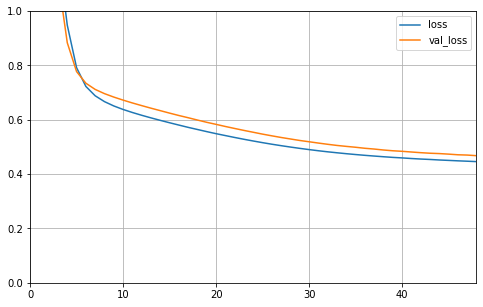

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(log_his)

In [12]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 18us/sample - loss: 0.4622


0.46220906131951384